In [2]:
import sys
import numpy as np
import cPickle
import h5py
sys.path.append('../..')
sys.path.append('../../..')
from tsne_python.tsne import tsne
import matplotlib.pyplot as plt
np.random.seed(7)
from sklearn.decomposition import PCA

gene_names = np.loadtxt('../../mouse_puberty_data/data/H_name_id.csv', dtype='S20')

def getHDF5Data(f):
    ff = h5py.File(f,mode='r')
    alldata = {}
    for k in ff.keys():
        alldata[k] = ff[k].value
    return alldata
def getPKLData(f):
    with open(f,'rb') as f:
        data = cPickle.load(f)
    return data

def plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, gender='male', transform='None', title=''):
    # N(1) * T(5) * Obs(183)    
    assert x_original.shape == x_gender.shape == x_opposite_gender.shape
    assert len(x_original.shape) == 3
    assert x_original.shape[0] == 1
      
    def calAbsDifference(x_original, x_gender):
        a = np.abs( (x_original-x_gender)/x_original )
        return np.ma.masked_invalid(a).mean()
    
    print 'abs diff. btw x_original, x_gender:', calAbsDifference(x_original, x_gender)
    
    T = x_original.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_original[0], x_gender[0], x_opposite_gender[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%.2f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%.2f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(1, 1+T), dtype=int)
    # Green is original
    plt_original = plt.scatter(Y[0:T, 0], Y[0:T, 1], s=20, c=label, marker='^', cmap='Oranges')
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='o', 
                         cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[2*T:3*T, 0], Y[2*T:3*T, 1], s=20, c=label, marker='x', 
                                  cmap=cmap)
    
    legend = plt.legend((plt_original, plt_gender, plt_opposite_gender),
           ('x_observe', 'x_gender', 'x_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('orange')
    legend.legendHandles[1].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[2].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(1, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    plt.title('%s %s counterfactual' % (title, gender))
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.show()
    print Y

def plotAllCfac(male_cfac, gender='male'):
    for index in male_cfac:
        x_original = male_cfac[index]['x']
        x_gender = male_cfac[index]['x_gender']
        x_opposite_gender = male_cfac[index]['x_opposite_gender']

        x_gender = np.concatenate((x_original[0:1,0:1,:], x_gender), axis=1)
        x_opposite_gender = np.concatenate((x_original[0:1,0:1,:], x_opposite_gender), axis=1)

        plotWithOriginalAndCfac(x_original, x_gender, x_opposite_gender, gender=gender, transform='PCA', title='x')

        z_gender = male_cfac[index]['z_gender']
        z_opposite_gender = male_cfac[index]['z_opposite_gender']
        
        if z_gender.shape[1] == 2:
            transform = 'None'
        elif z_gender.shape[1] > 2:
            transform = 'PCA'
        
        plotCfac(z_gender, z_opposite_gender, gender=gender, transform=transform, title='z')

    #     print x_original[0][2]
    #     print x_gender[0][2]
    #     ratio = np.absolute(x_original[0][2]-x_gender[0][2]) / np.absolute(x_original[0][2])
    #     print np.ma.masked_invalid(ratio).sum()
    #     print ratio
    #     break

def plotCfac(x_gender, x_opposite_gender, gender='male', transform='None', title=''):
    
    # N(1) * T(5) * Obs(183)    
    assert x_opposite_gender.shape == x_gender.shape
    assert len(x_gender.shape) == 3
    assert x_gender.shape[0] == 1
    
    T = x_gender.shape[1]
    # 3T * Obs(183)
    X = np.concatenate((x_gender[0], x_opposite_gender[0]), axis=0)
    
    if transform == 'PCA':
        pca = PCA(n_components=2)
        Y=pca.fit_transform(X)
        axis1_ratio = pca.explained_variance_ratio_[0]
        axis2_ratio = pca.explained_variance_ratio_[1]
        axis1_text = 'PC 1 (%f%%)' % (axis1_ratio*100)
        axis2_text = 'PC 2 (%f%%)' % (axis2_ratio*100)
    elif transform == 'tsne':
        Y = tsne(X, 2, 50, 30.0, quiet=True)
        axis1_text = 'tsne axis 1'
        axis2_text = 'tsne axis 2'
    elif transform == 'None':
        Y = X
        axis1_text = 'hidden state 1'
        axis2_text = 'hidden state 2'
    print 'Y shape:', Y.shape
    print 'T', T
    
    label = np.array(range(2, 2+T), dtype=int)
    # Green is original
    cmap = 'Blues' if gender == 'male' else 'Reds'
    plt_gender = plt.scatter(Y[:T, 0], Y[:T, 1], s=20, c=label, marker='o', cmap=cmap)
    cmap = 'Reds' if gender == 'male' else 'Blues'
    plt_opposite_gender = plt.scatter(Y[T:2*T, 0], Y[T:2*T, 1], s=20, c=label, marker='x', cmap=cmap)
    
    legend = plt.legend((plt_gender, plt_opposite_gender),
           ('z_gender', 'z_opposite_gender'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
    legend.legendHandles[0].set_color('blue' if gender=='male' else 'red')
    legend.legendHandles[1].set_color('red' if gender=='male' else 'blue')
    
    cbar = plt.colorbar()
    labels = np.arange(2, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)
    cbar.ax.set_ylabel('time growth (from light to dark)', rotation=270, labelpad=20)
    
    
    plt.xlabel(axis1_text)
    plt.ylabel(axis2_text)
    plt.title('%s %s counterfactual' % (title, gender))
    plt.show()

abs diff. btw x_original, x_gender: 0.427833420214
Y shape: (15, 2)
T 5


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide


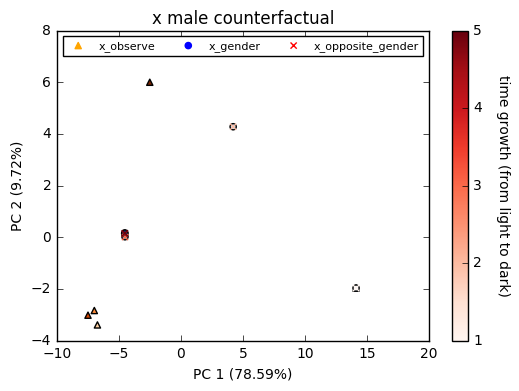

[[  1.41264814e+01  -1.97014694e+00]
 [ -6.72961152e+00  -3.39657834e+00]
 [ -6.98022391e+00  -2.83938841e+00]
 [ -7.49013357e+00  -3.02010677e+00]
 [ -2.50770458e+00   5.99719080e+00]
 [  1.41264814e+01  -1.97014694e+00]
 [  4.21571680e+00   4.27448672e+00]
 [ -4.50719423e+00   1.53815210e-02]
 [ -4.53164169e+00   1.47704705e-01]
 [ -4.51686789e+00   1.64571726e-01]
 [  1.41264814e+01  -1.97014694e+00]
 [  4.21571680e+00   4.27448672e+00]
 [ -4.50352855e+00   4.79722401e-03]
 [ -4.52932819e+00   1.35549009e-01]
 [ -4.51464352e+00   1.52345903e-01]]
Y shape: (8, 2)
T 4


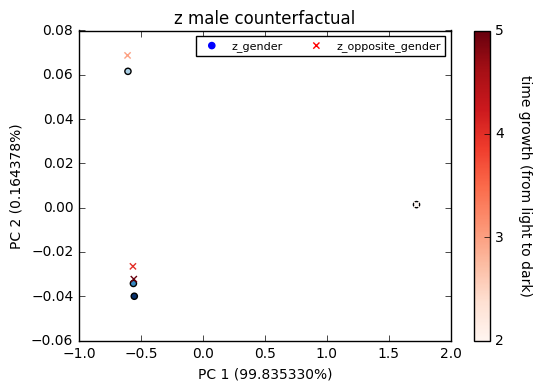

abs diff. btw x_original, x_gender: 0.507834662972
Y shape: (15, 2)
T 5


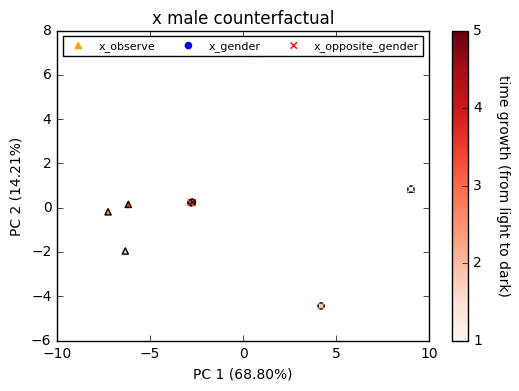

[[ 9.02833201  0.83699192]
 [-6.32843319 -1.95756225]
 [-7.25442773 -0.18861551]
 [-6.16892493  0.14828298]
 [ 0.80666555  6.97165533]
 [ 9.02833201  0.83699192]
 [ 4.19864694 -4.44057189]
 [-2.80209575  0.22025816]
 [-2.7371569   0.24489882]
 [-2.71963117  0.23777172]
 [ 9.02833201  0.83699192]
 [ 4.19864694 -4.44057189]
 [-2.80720905  0.21656136]
 [-2.74424788  0.2419944 ]
 [-2.72682884  0.23492299]]
Y shape: (8, 2)
T 4


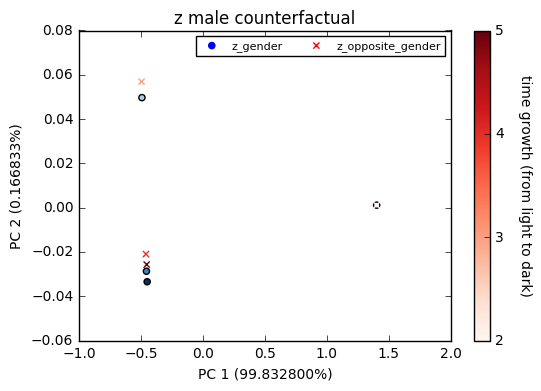

abs diff. btw x_original, x_gender: 0.421961139941
Y shape: (15, 2)
T 5


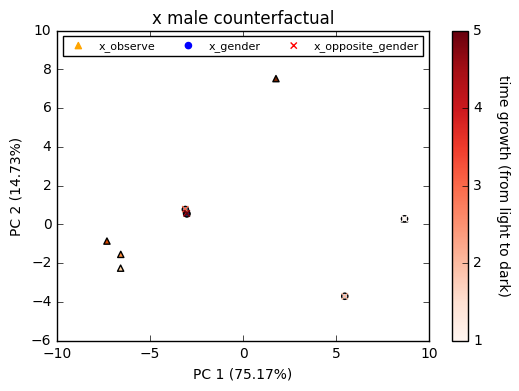

[[ 8.6844791   0.28233136]
 [-6.57979923 -2.26600213]
 [-6.57181189 -1.55467294]
 [-7.31492805 -0.86844677]
 [ 1.77259392  7.51629662]
 [ 8.6844791   0.28233136]
 [ 5.47185808 -3.71636244]
 [-3.0994448   0.76185475]
 [-3.03348961  0.55654879]
 [-3.01311517  0.53457798]
 [ 8.6844791   0.28233136]
 [ 5.47185808 -3.71636244]
 [-3.10181956  0.77792431]
 [-3.03780149  0.57476438]
 [-3.01753756  0.55288579]]
Y shape: (8, 2)
T 4


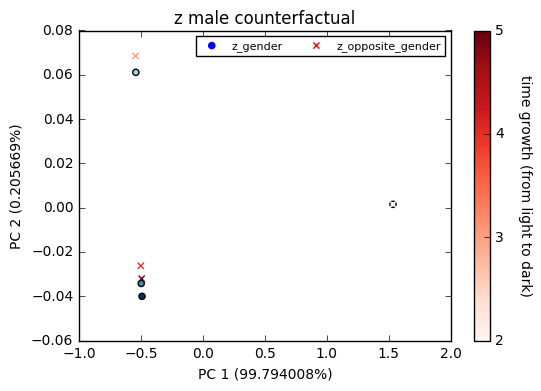

abs diff. btw x_original, x_gender: 0.572917417577
Y shape: (15, 2)
T 5


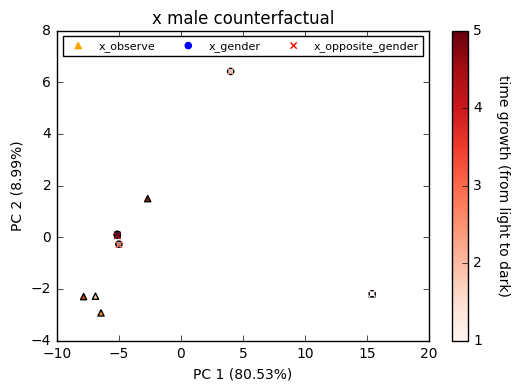

[[ 15.42833791  -2.18905081]
 [ -6.88674223  -2.28457998]
 [ -6.44220565  -2.93201547]
 [ -7.84311356  -2.3011665 ]
 [ -2.67706029   1.49160478]
 [ 15.42833791  -2.18905081]
 [  4.0135399    6.41557875]
 [ -4.99797751  -0.27167666]
 [ -5.13019813   0.07780315]
 [ -5.12212864   0.11340363]
 [ 15.42833791  -2.18905081]
 [  4.0135399    6.41557875]
 [ -4.98501384  -0.29528073]
 [ -5.11782923   0.05121387]
 [ -5.10982444   0.08668887]]
Y shape: (8, 2)
T 4


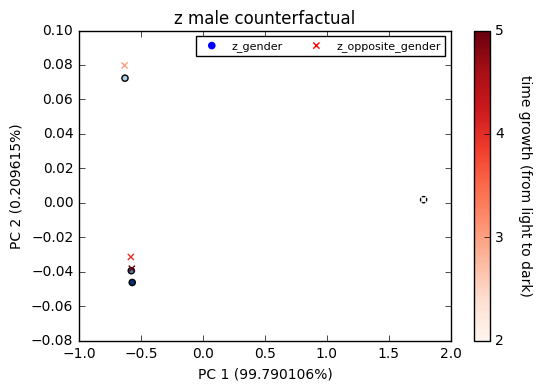

abs diff. btw x_original, x_gender: 0.438350556259
Y shape: (15, 2)
T 5


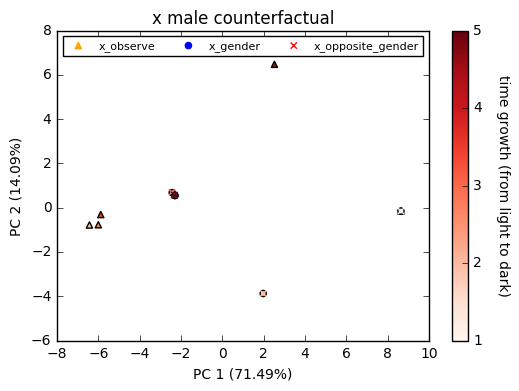

[[ 8.64287224 -0.15370011]
 [-6.42947623 -0.78334506]
 [-5.99976623 -0.7725201 ]
 [-5.88160638 -0.31276664]
 [ 2.5198322   6.4726788 ]
 [ 8.64287224 -0.15370011]
 [ 1.97726008 -3.87707949]
 [-2.42542152  0.67815418]
 [-2.30500851  0.55865173]
 [-2.28854892  0.54195673]
 [ 8.64287224 -0.15370011]
 [ 1.97726008 -3.87707949]
 [-2.44175323  0.69430363]
 [-2.32386664  0.57736211]
 [-2.30752142  0.56078395]]
Y shape: (8, 2)
T 4


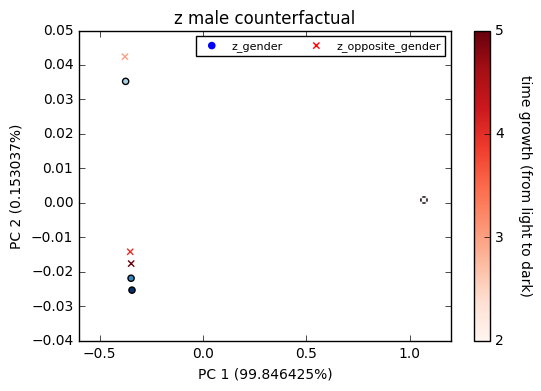

abs diff. btw x_original, x_gender: 0.648262237523
Y shape: (15, 2)
T 5


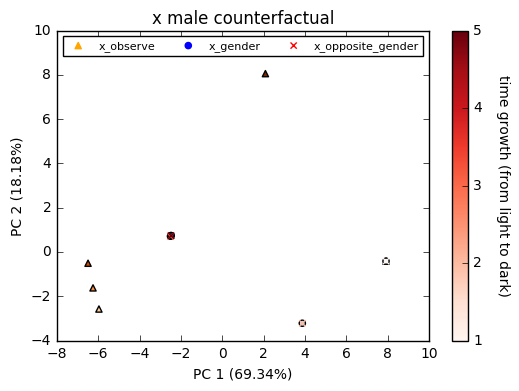

[[ 7.92603946 -0.41643567]
 [-5.96485337 -2.57847181]
 [-6.25122305 -1.62440932]
 [-6.49188197 -0.51076481]
 [ 2.09037466  8.05192014]
 [ 7.92603946 -0.41643567]
 [ 3.87607001 -3.2203832 ]
 [-2.5038051   0.70903871]
 [-2.48205027  0.73948253]
 [-2.46870437  0.73421902]
 [ 7.92603946 -0.41643567]
 [ 3.87607001 -3.2203832 ]
 [-2.50386726  0.70404287]
 [-2.48374793  0.73511541]
 [-2.47049974  0.72990065]]
Y shape: (8, 2)
T 4


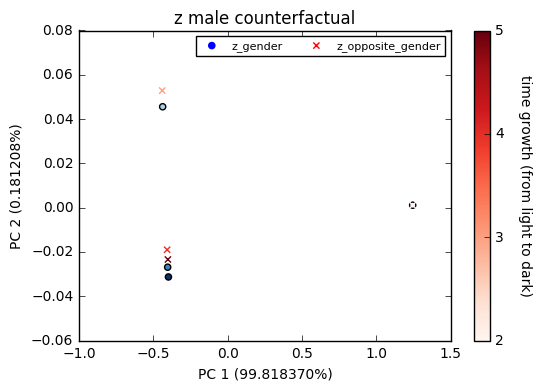

In [89]:
# For only gender. Quite FAIL!
expt = 'H-gender'
uid = 'DKF_lr-8_0000e-04-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-5_0000e-02-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)

cfac = getPKLData(cfac_file)
male_cfac = cfac['male_cfac']

plotAllCfac(male_cfac)   

abs diff. btw x_original, x_gender: 0.421567666646
Y shape: (15, 2)
T 5


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide


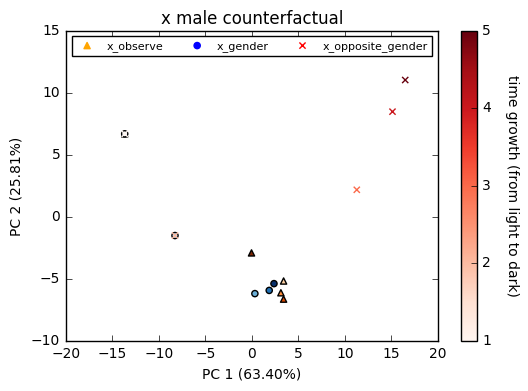

[[-13.66094196   6.66668693]
 [  3.42442878  -5.20239653]
 [  3.13315585  -6.14995552]
 [  3.42405868  -6.66338351]
 [ -0.02522871  -2.93565091]
 [-13.66094196   6.66668693]
 [ -8.25424091  -1.53562286]
 [  0.33725494  -6.21869976]
 [  1.87848155  -5.96114418]
 [  2.38974656  -5.41433073]
 [-13.66094196   6.66668693]
 [ -8.25424091  -1.53562286]
 [ 11.29430151   2.15405753]
 [ 15.13283985   8.45491156]
 [ 16.50226868  11.00777698]]
Y shape: (8, 2)
T 4


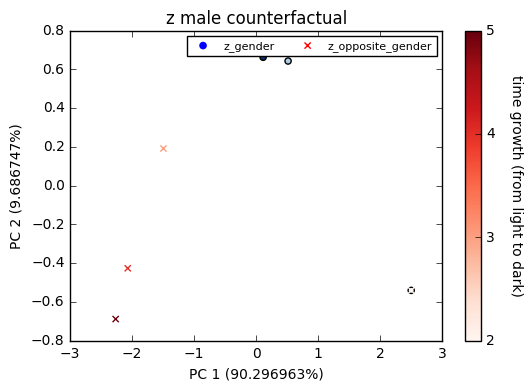

abs diff. btw x_original, x_gender: 0.480378243444
Y shape: (15, 2)
T 5


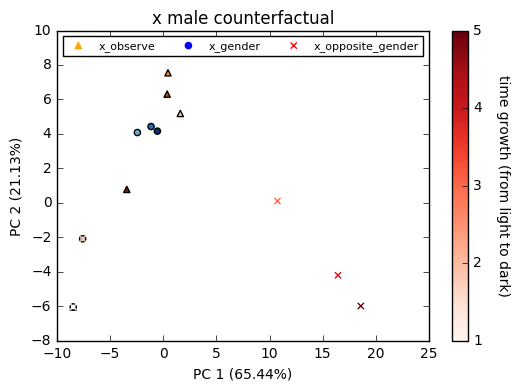

[[ -8.47664102  -6.05253379]
 [  1.60216292   5.18231305]
 [  0.44100666   7.54197128]
 [  0.36715595   6.30538339]
 [ -3.43165993   0.77359147]
 [ -8.47664102  -6.05253379]
 [ -7.58664437  -2.09474921]
 [ -2.43633228   4.0760092 ]
 [ -1.15045896   4.42291378]
 [ -0.55596796   4.1560074 ]
 [ -8.47664102  -6.05253379]
 [ -7.58664437  -2.09474921]
 [ 10.7432104    0.10051169]
 [ 16.43933836  -4.21399509]
 [ 18.58475663  -5.99760639]]
Y shape: (8, 2)
T 4


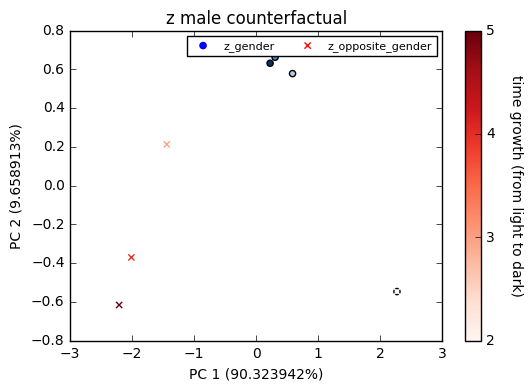

abs diff. btw x_original, x_gender: 0.404299007174
Y shape: (15, 2)
T 5


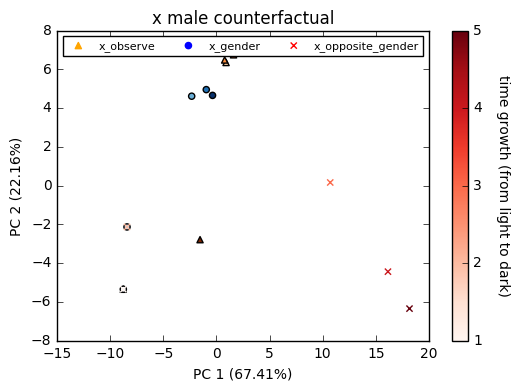

[[ -8.76180231  -5.3541625 ]
 [  0.90697256   6.34856083]
 [  0.77491874   6.47744686]
 [  1.60896183   6.74547313]
 [ -1.54178791  -2.79589808]
 [ -8.76180231  -5.3541625 ]
 [ -8.41290111  -2.13872174]
 [ -2.32806312   4.60897033]
 [ -0.95521116   4.9484461 ]
 [ -0.36607223   4.65123461]
 [ -8.76180231  -5.3541625 ]
 [ -8.41290111  -2.13872174]
 [ 10.70805479   0.15552462]
 [ 16.13814823  -4.44600466]
 [ 18.1652874   -6.35382276]]
Y shape: (8, 2)
T 4


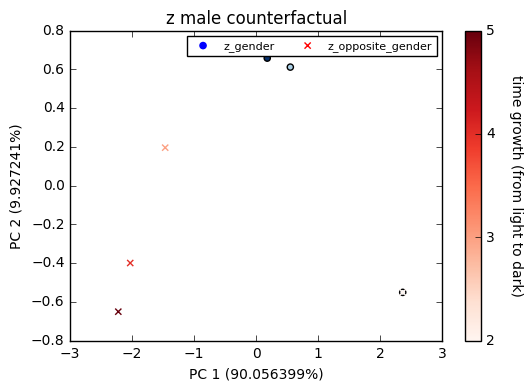

abs diff. btw x_original, x_gender: 0.567707708218
Y shape: (15, 2)
T 5


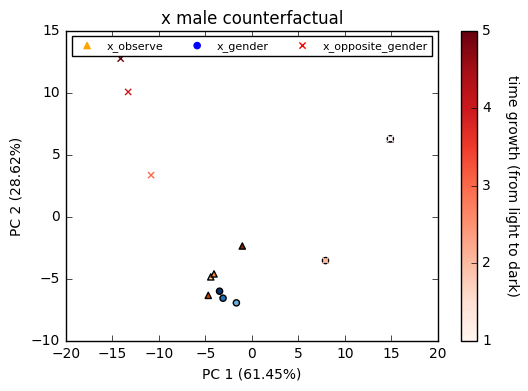

[[ 14.90272752   6.27075663]
 [ -4.40722254  -4.87028576]
 [ -4.05852228  -4.63053826]
 [ -4.67488875  -6.35993064]
 [ -1.01561698  -2.37974481]
 [ 14.90272752   6.27075663]
 [  7.93024984  -3.55410778]
 [ -1.65292285  -6.96447506]
 [ -3.08812542  -6.5879733 ]
 [ -3.46056818  -6.02544766]
 [ 14.90272752   6.27075663]
 [  7.93024984  -3.55410778]
 [-10.82563472   3.33462982]
 [-13.28819322  10.04758307]
 [-14.0969873   12.73212829]]
Y shape: (8, 2)
T 4


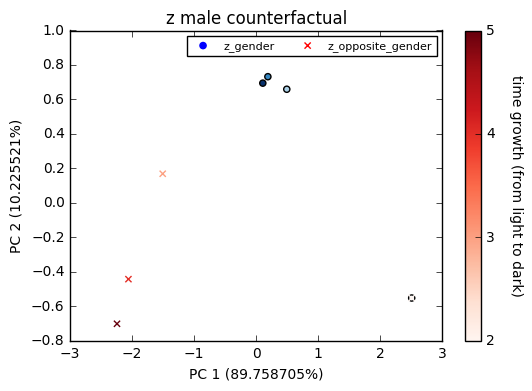

abs diff. btw x_original, x_gender: 0.419367158926
Y shape: (15, 2)
T 5


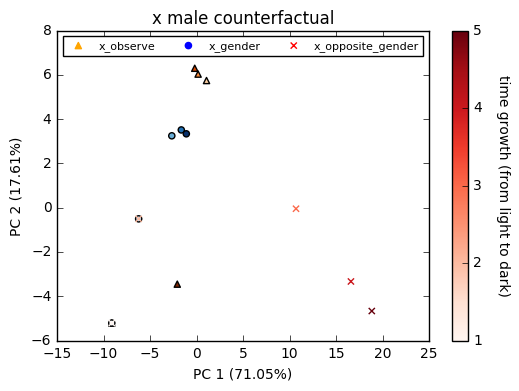

[[ -9.10877401  -5.21194548]
 [  1.07739921   5.74067275]
 [  0.17369187   6.03131308]
 [ -0.19024896   6.29501106]
 [ -2.06634483  -3.45446622]
 [ -9.10877401  -5.21194548]
 [ -6.21943316  -0.50636995]
 [ -2.65619761   3.24400883]
 [ -1.6344798    3.50965405]
 [ -1.09396384   3.33415648]
 [ -9.10877401  -5.21194548]
 [ -6.21943316  -0.50636995]
 [ 10.70067702  -0.04814687]
 [ 16.60597862  -3.33462569]
 [ 18.84867669  -4.66900115]]
Y shape: (8, 2)
T 4


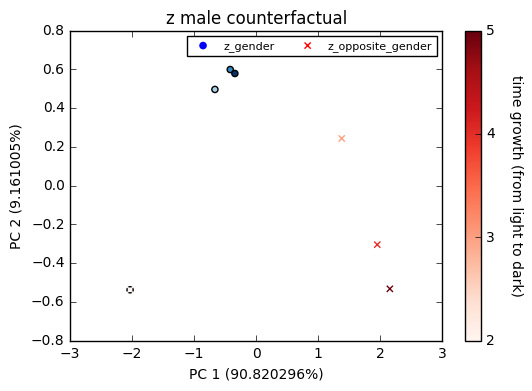

abs diff. btw x_original, x_gender: 0.678548306623
Y shape: (15, 2)
T 5


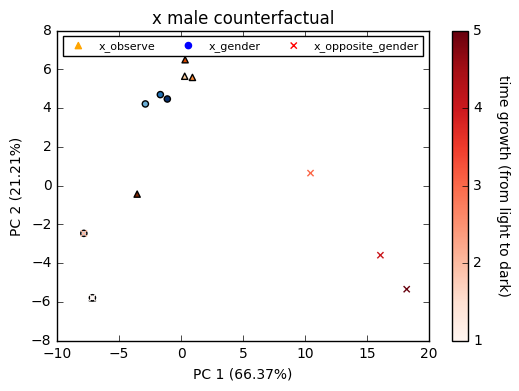

[[ -7.1439113   -5.7933054 ]
 [  0.29904464   5.6389703 ]
 [  0.92212987   5.57834347]
 [  0.33268856   6.49059407]
 [ -3.53588982  -0.44365128]
 [ -7.1439113   -5.7933054 ]
 [ -7.83600714  -2.46952239]
 [ -2.8743967    4.20924287]
 [ -1.6649393    4.69070044]
 [ -1.10268805   4.46492136]
 [ -7.1439113   -5.7933054 ]
 [ -7.83600714  -2.46952239]
 [ 10.44509271   0.6393242 ]
 [ 16.08129706  -3.59713512]
 [ 18.20140918  -5.35234935]]
Y shape: (8, 2)
T 4


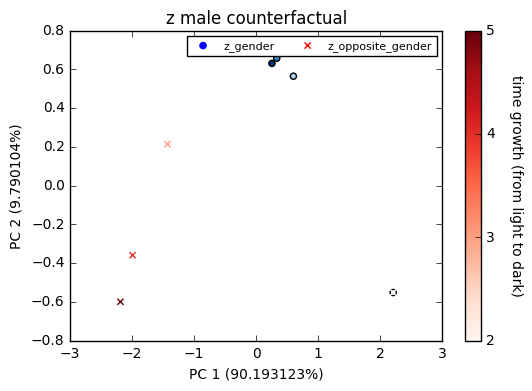

In [90]:
# For time gender. Looks better.
expt = 'H-time-gender'
uid = 'DKF_lr-8_0000e-04-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-5_0000e-02-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)

cfac = getPKLData(cfac_file)
male_cfac = cfac['male_cfac']

plotAllCfac(male_cfac)

Y shape: (15, 2)
T 5


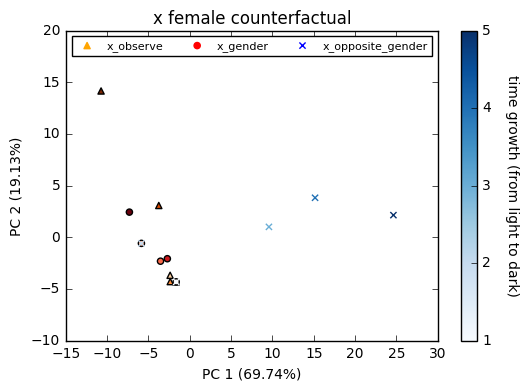

[[ -1.64255797  -4.32656821]
 [ -2.3734365   -3.68993705]
 [ -2.35841481  -4.3002081 ]
 [ -3.74516877   3.06587459]
 [-10.72764064  14.14757555]
 [ -1.64255797  -4.32656821]
 [ -5.84666063  -0.59867003]
 [ -3.53767864  -2.32525826]
 [ -2.71061133  -2.08524052]
 [ -7.30037168   2.42377855]
 [ -1.64255797  -4.32656821]
 [ -5.84666063  -0.59867003]
 [  9.57861998   0.99636297]
 [ 15.1591267    3.81297911]
 [ 24.63657086   2.13111784]]
Y shape: (8, 2)
T 4


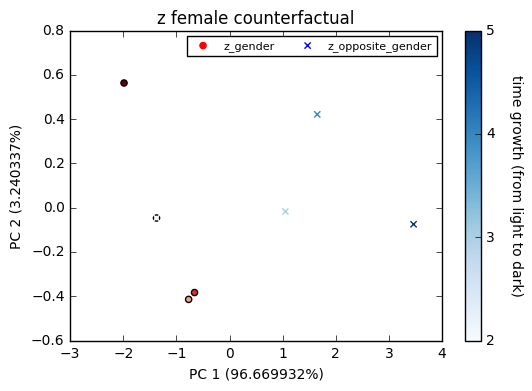

Y shape: (15, 2)
T 5


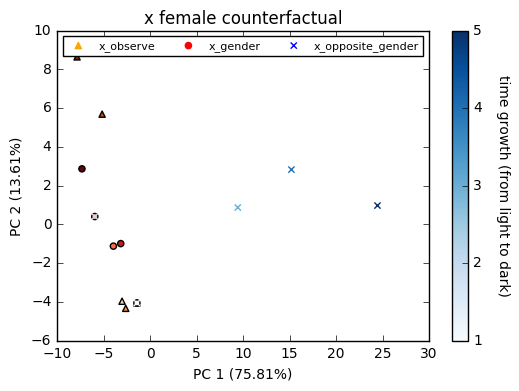

[[ -1.40845608  -4.06123233]
 [ -3.00477029  -3.97249727]
 [ -2.61044762  -4.33886795]
 [ -5.14667409   5.68259794]
 [ -7.84348585   8.63782428]
 [ -1.40845608  -4.06123233]
 [ -5.93589428   0.39762061]
 [ -3.93636513  -1.12970491]
 [ -3.14593483  -0.99899183]
 [ -7.31788004   2.85957586]
 [ -1.40845608  -4.06123233]
 [ -5.93589428   0.39762061]
 [  9.43814615   0.86343241]
 [ 15.20511883   2.82024117]
 [ 24.4594497    0.96484607]]
Y shape: (8, 2)
T 4


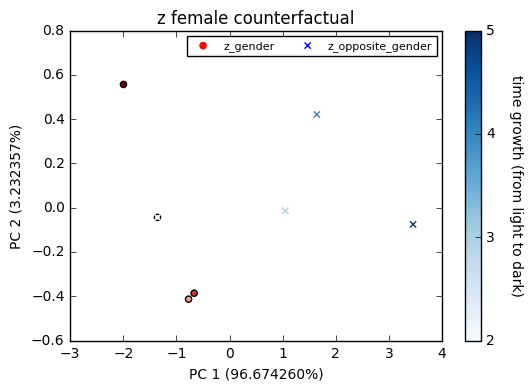

Y shape: (15, 2)
T 5


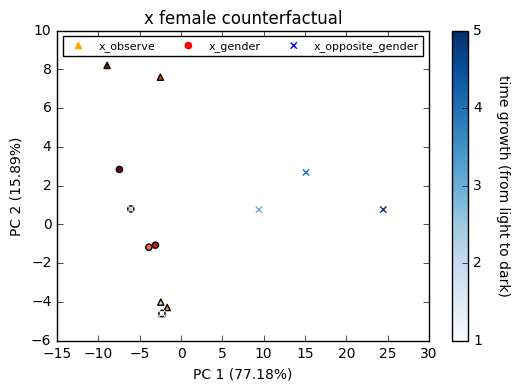

[[ -2.3024365   -4.60430493]
 [ -2.4450817   -4.01798936]
 [ -1.66592357  -4.29575348]
 [ -2.49354757   7.58932842]
 [ -8.9391021    8.19976841]
 [ -2.3024365   -4.60430493]
 [ -6.06749785   0.79089629]
 [ -3.8836444   -1.18399648]
 [ -3.09415296  -1.08016197]
 [ -7.45079725   2.82750277]
 [ -2.3024365   -4.60430493]
 [ -6.06749785   0.79089629]
 [  9.42509889   0.75733048]
 [ 15.11703166   2.67651656]
 [ 24.47242419   0.75857688]]
Y shape: (8, 2)
T 4


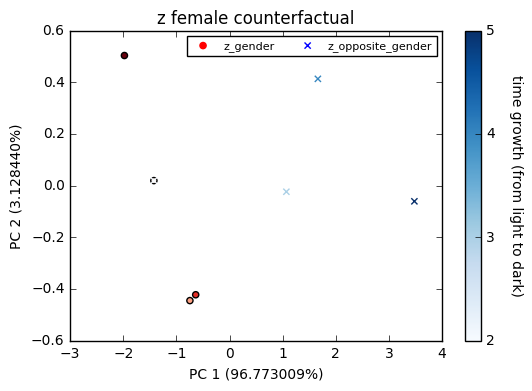

Y shape: (15, 2)
T 5


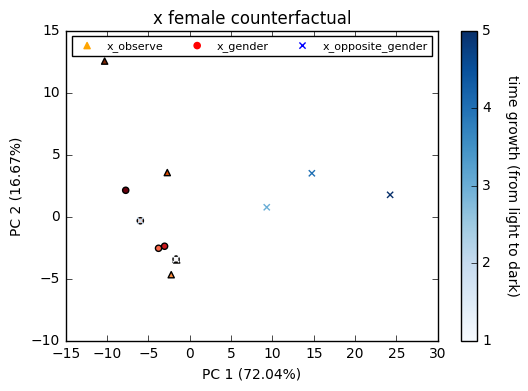

[[ -1.65435649  -3.44173303]
 [ -1.58211508  -3.50198704]
 [ -2.24259588  -4.69407487]
 [ -2.71613041   3.54207467]
 [-10.29608333  12.53300295]
 [ -1.65435649  -3.44173303]
 [ -5.97880858  -0.34293625]
 [ -3.77521008  -2.56255916]
 [ -3.04454963  -2.39882152]
 [ -7.74713165   2.11410031]
 [ -1.65435649  -3.44173303]
 [ -5.97880858  -0.34293625]
 [  9.31473557   0.74510187]
 [ 14.77119002   3.48546835]
 [ 24.23857711   1.74876604]]
Y shape: (8, 2)
T 4


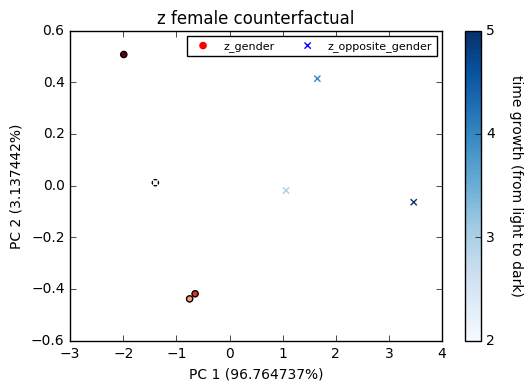

Y shape: (15, 2)
T 5


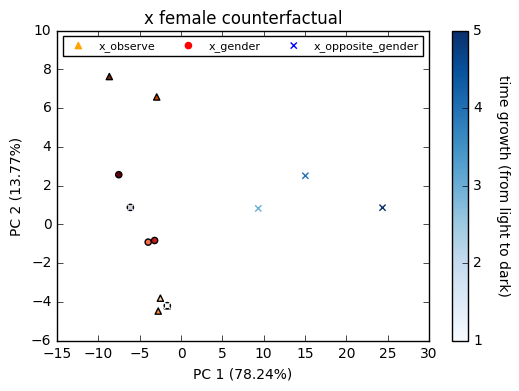

[[ -1.65941366  -4.20216968]
 [ -2.49505839  -3.81620752]
 [ -2.75461543  -4.48107709]
 [ -2.93636744   6.56915697]
 [ -8.66801628   7.62357226]
 [ -1.65941366  -4.20216968]
 [ -6.12527438   0.86915664]
 [ -3.97031451  -0.92223639]
 [ -3.19369961  -0.83822409]
 [ -7.52779452   2.55789489]
 [ -1.65941366  -4.20216968]
 [ -6.12527438   0.86915664]
 [  9.3521032    0.81711457]
 [ 15.04442085   2.50255198]
 [ 24.37813189   0.85565017]]
Y shape: (8, 2)
T 4


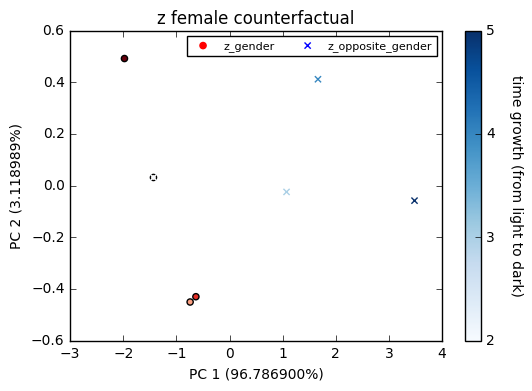

Y shape: (15, 2)
T 5


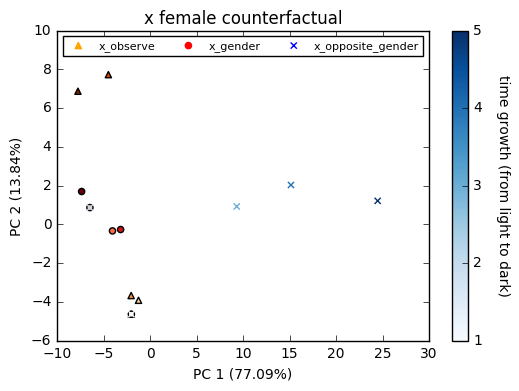

[[ -2.00341207  -4.64352141]
 [ -1.23530706  -3.92394716]
 [ -2.02728314  -3.67962653]
 [ -4.47421614   7.7219669 ]
 [ -7.7480877    6.86657481]
 [ -2.00341207  -4.64352141]
 [ -6.46016492   0.86018758]
 [ -4.03511082  -0.34315606]
 [ -3.15953131  -0.27274451]
 [ -7.35162504   1.68957665]
 [ -2.00341207  -4.64352141]
 [ -6.46016492   0.86018758]
 [  9.32520607   0.91828466]
 [ 15.15739045   2.02590756]
 [ 24.47913075   1.20735275]]
Y shape: (8, 2)
T 4


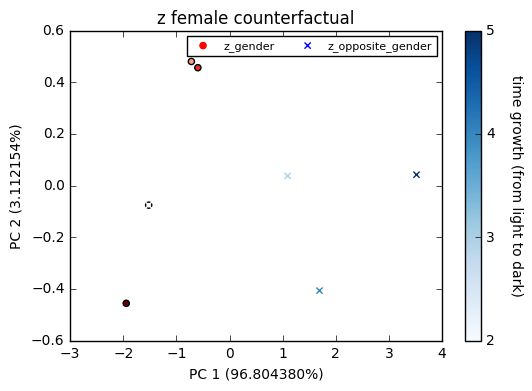

In [85]:
# For female time gender. Looks better.
expt = 'H-time-gender'
uid = 'DKF_lr-8_0000e-04-vm-R-inf-structured-dh-10-ds-10-nl-relu-bs-256-ep-3000-rs-20-ar-1_0000e+01-rv-5_0000e-02-uid'
cfac_file = '../../expt-mouse-puberty/chkpt-%s/%s-cfac.pkl' % (expt, uid)

cfac = getPKLData(cfac_file)
female_cfac = cfac['female_cfac']

plotAllCfac(female_cfac, gender='female')